# MEDICAL TEXT CLASSIFICATION USING GRU MODEL WITH MULTIPLE EMBEDDINGS

## Objective
Multi-class medical symptom classification using GRU with four different embedding approaches:
1. TF-IDF
2. Word2Vec
3. GloVe
4. FastText

## Key Dataset Decisions
- **Task**: Multi-class medical symptom classification
- **Input**: Tokenized clinical descriptions
- **Evaluation metrics**: Accuracy + Macro F1
- **Labels**: Integer-encoded for compatibility with cross-entropy loss

# Imports & Configurations

In [41]:
import os
import requests, zipfile, io
import pandas as pd
from collections import Counter
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec
from gensim.models import FastText
import matplotlib.pyplot as plt

%matplotlib inline

## Download NLTK resources

Download NLTK resources like stopwords and wordnet beforehand

In [17]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/degide/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/degide/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Preprocessing


## Define custom medical stopwords

These add noise to the system classifying medical text

In [19]:
# Define custom medical stopwords
medical_stopwords = ['patient', 'doctor', 'history', 'year', 'years', 'old', 'complains', 'presented', 'hospital']
stop_words_set = set(stopwords.words('english')).union(set(medical_stopwords))

Next, we define the word lemmatizer

In [20]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

Utility function to preprocess raw text:

In [22]:
# Text preprocessing function
def preprocess_text(text, use_lemmatization=False):
    # Lowercase the text
    text = text.lower()
    
    # Allow numbers (a-z and 0-9)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    
    # Tokenize the text
    words = text.split()
    
    # Remove stopwords
    words = [word for word in words if word not in stop_words_set]
    
    # Apply lemmatization if specified
    if use_lemmatization:
        words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)

## Dataset loading

In this part, we load the dataset and apply the preprocessing

In [23]:
# Load dataset
df = pd.read_csv('../dataset/medical_llm_dataset.csv')

# Apply preprocessing to the text column without lemmatization
df['clean_text'] = df['text'].apply(lambda x: preprocess_text(x, use_lemmatization=False))

Utility functions to build word vocabulary and convert text to sequenses:

In [24]:
# Build vocabulary
def build_vocabulary(text_series, max_vocab_size=5000):
    # Count all words
    all_words = [word for text in text_series for word in text.split()]
    word_counts = Counter(all_words)

    # Keep only most common words (to avoid massive memory usage)
    most_common = word_counts.most_common(max_vocab_size - 2)  # Reserve 2 spots for PAD and UNK

    # Create mapping: word -> index (int)
    vocab = {word: i+2 for i, (word, _) in enumerate(most_common)}
    vocab['<PAD>'] = 0  # Padding token
    vocab['<UNK>'] = 1  # Unknown token

    return vocab

# Convert text to sequences (Padded)
def text_to_sequence(text, vocab, max_len=50):
    tokens = text.split()

    # Convert to intergers (use <UNK> token if word not in vocab)
    seq = [vocab.get(token, vocab['<UNK>']) for token in tokens]

    # Truncate if too long
    if len(seq) > max_len:
        seq = seq[:max_len]
    # Pad if too short
    else:
        seq += [vocab['<PAD>']] * (max_len - len(seq))

    return seq

In [25]:
# --- EXECUTION ---
# Build vocabulary from cleaned/training text only (to prevent data leakage)
vocab = build_vocabulary(df['clean_text'], max_vocab_size=5000)

# Convert cleaned text to sequences
# This creates a matrix of shape (num_samples, max_len)
x_indices = np.array([text_to_sequence(text, vocab, max_len=50) for text in df['clean_text']])

print("Vocabulary Size:", len(vocab))
print("Sample sequence (first entry):", x_indices[0])

Vocabulary Size: 645
Sample sequence (first entry): [ 12   8   2  74 638  97   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


## Dataset Visualizations

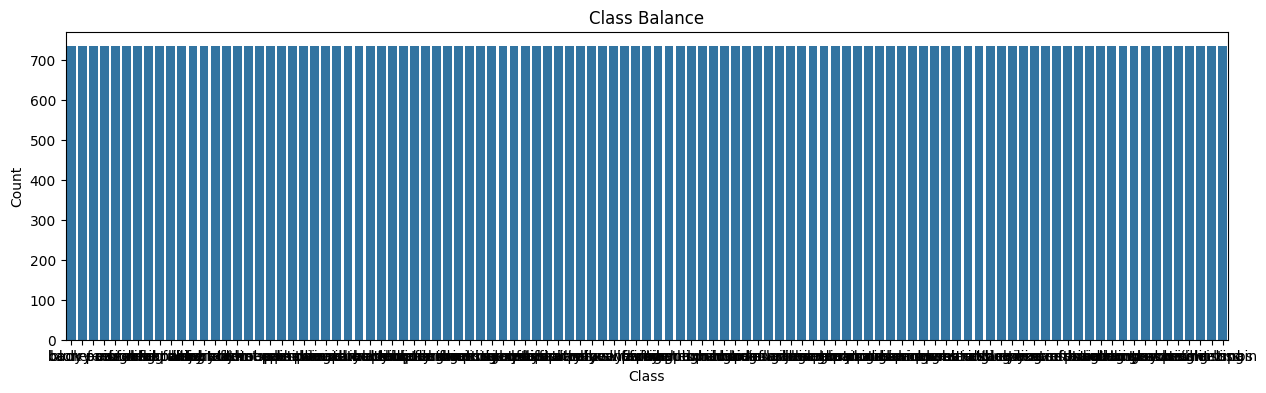

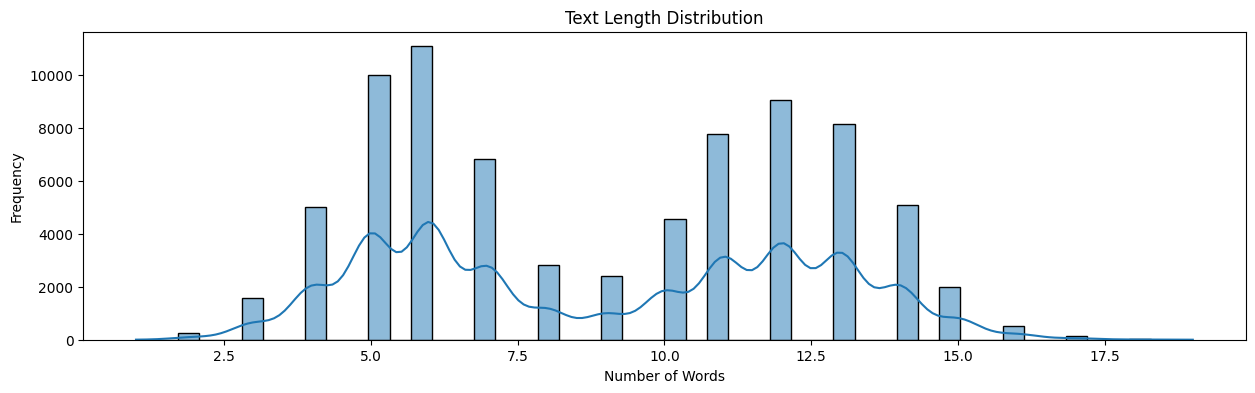

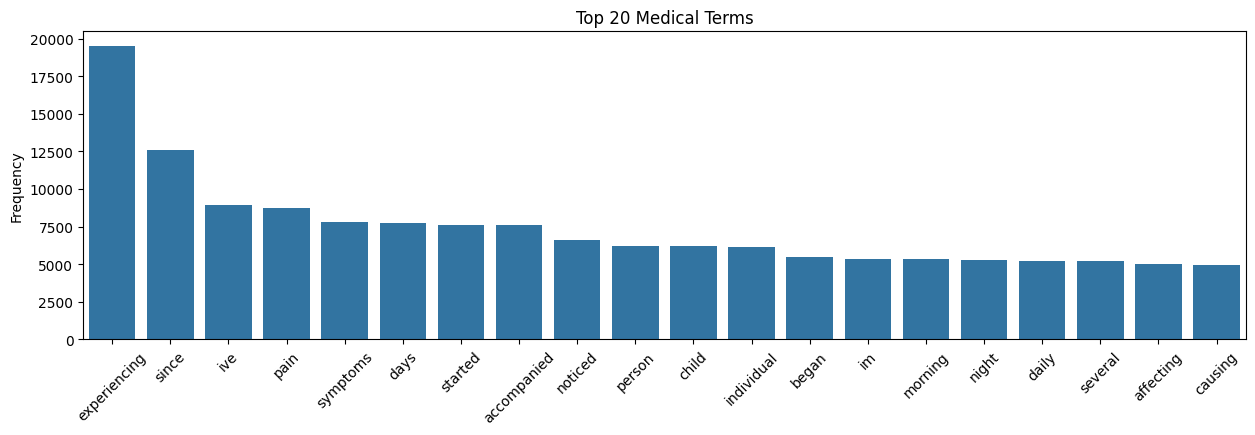

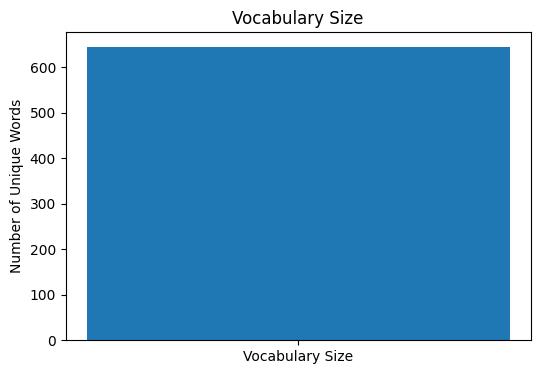

In [26]:
# Class Balance
plt.figure(figsize=(15,4))
sns.countplot(x='label_enc', data=df)
plt.title('Class Balance')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Text Length Distribution
text_lengths = df['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(15,4))
sns.histplot(text_lengths, bins=50, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Top 20 Medical Terms
all_words = [word for text in df['clean_text'] for word in text.split()]
word_freq = Counter(all_words)
top_20 = word_freq.most_common(20)
terms, counts = zip(*top_20)
plt.figure(figsize=(15,4))
sns.barplot(x=list(terms), y=list(counts))
plt.title('Top 20 Medical Terms')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

# Vocabulary Size
plt.figure(figsize=(6,4))
plt.bar(['Vocabulary Size'], [len(vocab)])
plt.title('Vocabulary Size')
plt.ylabel('Number of Unique Words')
plt.show()

# GRU Model

In [38]:
def build_gru_model(vocab_size, embedding_dim, max_len, embedding_matrix=None, is_tfidf=False, num_classes=5):
    """
    Universal GRU builder.
    - If is_tfidf=True: Expects input shape (1, vocab_size) -> Direct GRU
    - If is_tfidf=False: Expects input shape (max_len,) -> Embedding -> GRU
    """
    
    if is_tfidf:
        # --- TF-IDF ARCHITECTURE ---
        # Input shape: (Time_Steps=1, Features=vocab_size)
        inputs = Input(shape=(1, vocab_size))
        # GRU processes the vector directly
        x = GRU(64, return_sequences=False)(inputs)
    
    else:
        # --- WORD EMBEDDING ARCHITECTURE ---
        # Input shape: (Sequence_Length=max_len)
        inputs = Input(shape=(max_len,))
        
        if embedding_matrix is not None:
            # Pre-trained (Word2Vec, GloVe, FastText)
            embed_layer = Embedding(
                input_dim=vocab_size,
                output_dim=embedding_dim,
                weights=[embedding_matrix],
                input_length=max_len,
                trainable=False, 
                mask_zero=True
            )(inputs)
        else:
            # Trainable (Baseline)
            embed_layer = Embedding(
                input_dim=vocab_size,
                output_dim=embedding_dim,
                input_length=max_len,
                mask_zero=True
            )(inputs)
            
        x = GRU(64, return_sequences=False)(embed_layer)

    # Common classification head
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [39]:
# Experiments

# Results storage
results = []

# 1. Split Data FIRST (Prevents Leakage)
X = df['clean_text']
y = df['label_enc'] # Replace with your actual target column name

# Encode labels if they aren't integers yet
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = len(le.classes_)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.1, random_state=42, stratify=y_enc
)

# 2. Build Vocabulary ONLY on Training Data
vocab = build_vocabulary(X_train_raw, max_vocab_size=5000)
print("Vocabulary Size:", len(vocab))

# 3. Convert text to sequences
X_train_seq = [text_to_sequence(text, vocab, max_len=50) for text in X_train_raw]
X_test_seq  = [text_to_sequence(text, vocab, max_len=50) for text in X_test_raw]

max_len = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print("Shape of X_train:", X_train_pad.shape)

Vocabulary Size: 645
Shape of X_train: (69457, 50)


# Experiments

In [40]:
# Experiment 1:  TF-IDF + GRU
# 1. Vectorize (Fit ONLY on Train)
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train_raw).toarray()
X_test_tfidf  = tfidf.transform(X_test_raw).toarray()

# 2. Reshape for GRU: (Samples, Time Steps, Features) -> (N, 1, 5000)
X_train_tfidf_reshaped = X_train_tfidf.reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
X_test_tfidf_reshaped  = X_test_tfidf.reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# 3. Build & Train
print("Training TF-IDF GRU...")
model_tfidf = build_gru_model(
    vocab_size=X_train_tfidf.shape[1], # 5000
    embedding_dim=64, # Not used for TF-IDF logic but required by function arg
    max_len=1,        # Time steps = 1
    is_tfidf=True,    # <--- Activates the TF-IDF logic
    num_classes=num_classes
)

model_tfidf.fit(
    X_train_tfidf_reshaped, 
    y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1,
    callbacks=[
		tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5),
		tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
	]
)

# 4. Evaluate
y_pred_tfidf = model_tfidf.predict(X_test_tfidf_reshaped).argmax(axis=1)
acc_tfidf = accuracy_score(y_test, y_pred_tfidf)
f1_tfidf = f1_score(y_test, y_pred_tfidf, average='weighted')

results.append(('TF-IDF', acc_tfidf, f1_tfidf))
print("TF-IDF Results:", acc_tfidf, f1_tfidf)

Training TF-IDF GRU...
Epoch 1/10
977/977 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6182 - loss: 2.0343 - val_accuracy: 0.9807 - val_loss: 0.1242 - learning_rate: 0.0010
Epoch 2/10
977/977 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9438 - loss: 0.2321 - val_accuracy: 0.9856 - val_loss: 0.0385 - learning_rate: 0.0010
Epoch 3/10
977/977 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9658 - loss: 0.1234 - val_accuracy: 0.9872 - val_loss: 0.0265 - learning_rate: 0.0010
Epoch 4/10
977/977 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9732 - loss: 0.0883 - val_accuracy: 0.9859 - val_loss: 0.0238 - learning_rate: 0.0010
Epoch 5/10
977/977 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9760 - loss: 0.0700 - val_accuracy: 0.9863 - val_loss: 0.0223 - learning_rate: 0.0010
Epoch 6/10
977/977 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9785 - loss: 0.0601 - val_accuracy: 0.9865 - val_loss: 0.0224 - learning_rate: 0.0010
Epoch 7/10
977/977 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0

In [43]:
# 1. Tokenize
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_raw) # Fit ONLY on Train

X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
X_test_seq  = tokenizer.texts_to_sequences(X_test_raw)

# 2. Pad
MAX_LEN = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')
vocab_size = len(tokenizer.word_index) + 1

In [44]:
# Experiment 2: Skip-gram (Word2Vec) + GRU
# Train Word2Vec ONLY on Training Data (Prevents Data Leakage)
#    We split the raw strings from the training set into lists of words.
sentence_list = [text.split() for text in X_train_raw]

w2v_model = Word2Vec(
    sentences=sentence_list,
    vector_size=64, 
    window=5, 
    min_count=1, 
    sg=1,  # 1 = Skip-gram, 0 = CBOW
    workers=4
)

# 2. Create Embedding Matrix
#    We map the Keras Tokenizer indices to the Gensim Word2Vec vectors.
embedding_matrix_sg = np.zeros((vocab_size, 64))
hit_count = 0
miss_count = 0

for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix_sg[i] = w2v_model.wv[word]
        hit_count += 1
    else:
        # Optional: Initialize OOV words with small random noise instead of zeros
        embedding_matrix_sg[i] = np.random.normal(scale=0.6, size=(64,))
        miss_count += 1

print(f"Word2Vec Coverage: {hit_count} hits, {miss_count} misses")

# 3. Build Model
model_skipgram = build_gru_model(
    vocab_size=vocab_size,
    embedding_dim=64,
    max_len=MAX_LEN,       # 50
    embedding_matrix=embedding_matrix_sg,
    is_tfidf=False,        # Use Embedding Layer
    num_classes=num_classes
)

# Re-compile to use your specific optimizer settings
model_skipgram.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Train (Using Padded Sequences)
print("Training Skip-gram GRU...")
model_skipgram.fit(
    X_train_pad, y_train, 
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ],
    epochs=10, 
    batch_size=128, 
    validation_split=0.1, 
    verbose=1,
)

# 5. Evaluate
y_pred_sg = model_skipgram.predict(X_test_pad).argmax(axis=1)
acc_sg = accuracy_score(y_test, y_pred_sg)
f1_sg = f1_score(y_test, y_pred_sg, average='weighted')

results.append(('Skip-gram', acc_sg, f1_sg))
print("Skip-gram Results:", acc_sg, f1_sg)

Word2Vec Coverage: 643 hits, 1 misses
Training Skip-gram GRU...
Epoch 1/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step - accuracy: 0.1803 - loss: 3.4639 - val_accuracy: 0.5638 - val_loss: 1.8776 - learning_rate: 0.0010
Epoch 2/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.5319 - loss: 1.6905 - val_accuracy: 0.7452 - val_loss: 1.0073 - learning_rate: 0.0010
Epoch 3/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.6850 - loss: 1.1064 - val_accuracy: 0.8314 - val_loss: 0.6220 - learning_rate: 0.0010
Epoch 4/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.7590 - loss: 0.7993 - val_accuracy: 0.8881 - val_loss: 0.4001 - learning_rate: 0.0010
Epoch 5/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - accuracy: 0.8102 - loss: 0.6048 - val_accuracy: 0.9331 - val_loss: 0.2628 - learning_rate: 0.0010
Epoch 6/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.8485 - loss: 0.4783 - val_accuracy: 0.9552 - val_loss: 0.1868 - learning_rate: 0.0010
Epoch 7/10
4

In [45]:
# Experiment 3: GloVe + GRU
# 1. Setup Paths & Download GloVe (if missing)
#    We use a local directory to store the heavy embedding file
glove_dir = os.path.join('..', 'dataset', 'glove.6B')
glove_file = 'glove.6B.100d.txt'
glove_path = os.path.join(glove_dir, glove_file)

if not os.path.exists(glove_path):
    print("Downloading GloVe embeddings (this may take a while)...")
    os.makedirs(glove_dir, exist_ok=True)
    
    url = 'https://nlp.stanford.edu/data/glove.6B.zip' # Note: switched to https
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extract(glove_file, path=glove_dir)
    print("Download and extraction complete.")
else:
    print("GloVe embeddings found.")

# 2. Load GloVe Embeddings into Memory
glove_index = {}
with open(glove_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_index[word] = coefs

print(f"Found {len(glove_index)} word vectors in GloVe.")

# 3. Create Embedding Matrix
#    Map our specific Tokenizer's vocabulary to GloVe vectors
embedding_dim = 100
embedding_matrix_glove = np.zeros((vocab_size, embedding_dim))
hits = 0
misses = 0

for word, i in tokenizer.word_index.items():
    embedding_vector = glove_index.get(word)
    if embedding_vector is not None:
        # Words found in GloVe
        embedding_matrix_glove[i] = embedding_vector
        hits += 1
    else:
        # Words NOT found (OOV) - Initialize with random noise or zeros
        embedding_matrix_glove[i] = np.random.normal(scale=0.6, size=(embedding_dim,))
        misses += 1

print(f"GloVe Coverage: {hits} hits, {misses} misses")

# 4. Build Model
model_glove = build_gru_model(
    vocab_size=vocab_size,
    embedding_dim=100,       # GloVe 100d
    max_len=MAX_LEN,         # 50
    embedding_matrix=embedding_matrix_glove,
    is_tfidf=False,
    num_classes=num_classes
)

# 5. Train
print("Training GloVe GRU...")
model_glove.fit(
    X_train_pad, y_train, 
    epochs=10, 
    batch_size=128, 
    validation_split=0.1, 
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5),
    ]
)

# 6. Evaluate
y_pred_glove = model_glove.predict(X_test_pad).argmax(axis=1)
acc_glove = accuracy_score(y_test, y_pred_glove)
f1_glove = f1_score(y_test, y_pred_glove, average='weighted')

results.append(('GloVe', acc_glove, f1_glove))
print("GloVe Results:", acc_glove, f1_glove)

GloVe embeddings found.
Found 400000 word vectors in GloVe.
GloVe Coverage: 630 hits, 14 misses
Training GloVe GRU...
Epoch 1/10


/home/degide/.mlvenv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


489/489 ━━━━━━━━━━━━━━━━━━━━ 32s 59ms/step - accuracy: 0.2394 - loss: 3.2279 - val_accuracy: 0.8290 - val_loss: 0.9139 - learning_rate: 0.0010
Epoch 2/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.7770 - loss: 0.7772 - val_accuracy: 0.9696 - val_loss: 0.1614 - learning_rate: 0.0010
Epoch 3/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 31s 64ms/step - accuracy: 0.9113 - loss: 0.3127 - val_accuracy: 0.9859 - val_loss: 0.0574 - learning_rate: 0.0010
Epoch 4/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - accuracy: 0.9445 - loss: 0.1875 - val_accuracy: 0.9872 - val_loss: 0.0345 - learning_rate: 0.0010
Epoch 5/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 31s 64ms/step - accuracy: 0.9571 - loss: 0.1384 - val_accuracy: 0.9886 - val_loss: 0.0272 - learning_rate: 0.0010
Epoch 6/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.9654 - loss: 0.1086 - val_accuracy: 0.9882 - val_loss: 0.0240 - learning_rate: 0.0010
Epoch 7/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.9677 - loss: 0.0961

In [46]:
# Experiment 4: FastText + GRU
# 1. Train FastText ONLY on Training Data (Prevents Data Leakage)
sentence_list = [text.split() for text in X_train_raw]

# FastText is great for medical data because it handles sub-words (suffixes/prefixes)
ft_model = FastText(
    sentences=sentence_list,
    vector_size=64, 
    window=5, 
    min_count=1, 
    workers=4
)

# 2. Create Embedding Matrix
embedding_dim = 64
embedding_matrix_ft = np.zeros((vocab_size, embedding_dim))
hits = 0
misses = 0

for word, i in tokenizer.word_index.items():
    if word in ft_model.wv:
        embedding_matrix_ft[i] = ft_model.wv[word]
        hits += 1
    else:
        # FastText can theoretically handle OOV via n-grams, 
        # but if the word is completely alien to the trained model structure:
        embedding_matrix_ft[i] = np.random.normal(scale=0.6, size=(embedding_dim,))
        misses += 1

print(f"FastText Coverage: {hits} hits, {misses} misses")

# 3. Build Model
model_ft = build_gru_model(
    vocab_size=vocab_size,
    embedding_dim=64,
    max_len=MAX_LEN,       # 50
    embedding_matrix=embedding_matrix_ft,
    is_tfidf=False,        # Use Embedding Layer
    num_classes=num_classes
)

# 4. Train
print("Training FastText GRU...")
model_ft.fit(
    X_train_pad, y_train, 
    epochs=10, 
    batch_size=128, 
    validation_split=0.1, 
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5),
    ]
)

# 5. Evaluate
y_pred_ft = model_ft.predict(X_test_pad).argmax(axis=1)
acc_ft = accuracy_score(y_test, y_pred_ft)
f1_ft = f1_score(y_test, y_pred_ft, average='weighted')

results.append(('FastText', acc_ft, f1_ft))
print("FastText Results:", acc_ft, f1_ft)

FastText Coverage: 644 hits, 0 misses
Training FastText GRU...
Epoch 1/10


/home/degide/.mlvenv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


489/489 ━━━━━━━━━━━━━━━━━━━━ 28s 52ms/step - accuracy: 0.2192 - loss: 3.4288 - val_accuracy: 0.7413 - val_loss: 1.3177 - learning_rate: 0.0010
Epoch 2/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 27s 56ms/step - accuracy: 0.7084 - loss: 1.0946 - val_accuracy: 0.8988 - val_loss: 0.4338 - learning_rate: 0.0010
Epoch 3/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 29s 60ms/step - accuracy: 0.8483 - loss: 0.5469 - val_accuracy: 0.9581 - val_loss: 0.1822 - learning_rate: 0.0010
Epoch 4/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 28s 58ms/step - accuracy: 0.8993 - loss: 0.3455 - val_accuracy: 0.9773 - val_loss: 0.1039 - learning_rate: 0.0010
Epoch 5/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.9277 - loss: 0.2449 - val_accuracy: 0.9798 - val_loss: 0.0649 - learning_rate: 0.0010
Epoch 6/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - accuracy: 0.9418 - loss: 0.1917 - val_accuracy: 0.9821 - val_loss: 0.0468 - learning_rate: 0.0010
Epoch 7/10
489/489 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - accuracy: 0.9499 - loss: 0.1585

In [50]:
# Save results to CSV
results_df = pd.DataFrame(results, columns=['Embedding_Method', 'Accuracy', 'F1_Score'])
results_df.to_csv('../results/gru_experiment_results.csv', index=False)

# Display results
print("\nFinal Results:")
results_df


Final Results:


,Embedding_Method,Accuracy,F1_Score
0,TF-IDF,0.987821,0.987702
1,Skip-gram,0.978751,0.978721
2,GloVe,0.986136,0.985028
3,FastText,0.985229,0.984958
